In [8]:
import numpy as np

In [9]:
# load the mnist dataset
def fetch(url):
  import requests, gzip, os, hashlib, numpy
  fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
  if os.path.isfile(fp):
    with open(fp, "rb") as f:
      dat = f.read()
  else:
    with open(fp, "wb") as f:
      dat = requests.get(url).content
      f.write(dat)
  return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()
X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 18

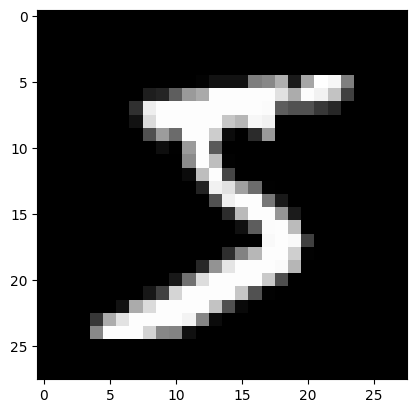

In [10]:
print(X_train[0])

import matplotlib.pyplot as plt

plt.imshow(X_train[0], cmap="gray")
plt.show()

In [51]:
from torch import nn

class MnistCnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.kernel_size = 5
        self.pool_size = 2

        self.pad = nn.ConstantPad2d(2, 0)

        # First conv blockl
        self.conv1 = nn.Conv2d(1, 6, self.kernel_size)
        self.conv_act1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(self.pool_size)

        # Second conv block
        self.conv2 = nn.Conv2d(6, 16, self.kernel_size)
        self.conv_act2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(self.pool_size)

        # Linear
        self.l1 = nn.Linear(16*5*5, 120)
        self.act1 = nn.ReLU()
        self.l2 = nn.Linear(120, 84)
        self.act2 = nn.ReLU()
        self.l3 = nn.Linear(84, 10)
        self.act3 = nn.ReLU()

        self.soft = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.pad(x)

        x = self.maxpool1(self.conv_act1(self.conv1(x)))
        x = self.maxpool2(self.conv_act2(self.conv2(x)))

        x = x.view(x.shape[0], -1)

        x = self.l1(x)
        x = self.act1(x)
        x = self.l2(x)
        x = self.act2(x)
        x = self.l3(x)
        x = self.act3(x)

        x = self.soft(x)

        return x

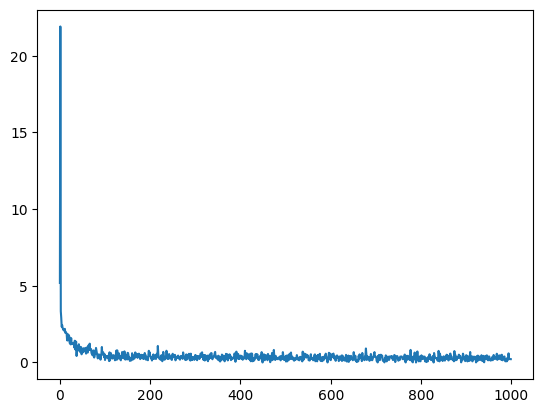

In [63]:
import torch

model = MnistCnn()
BS = 32

loss_function = nn.NLLLoss()
optim = torch.optim.RMSprop(model.parameters(), lr=0.001)
loses = []
for i in range(1000):
    samp = np.random.randint(0, X_test.shape[0], size=(BS, 1))
    inpt = torch.tensor(X_test[samp]).float()
    samp = samp.reshape(BS)
    target = torch.tensor(Y_test[samp])
    optim.zero_grad()
    guess = model(inpt)
    loss = loss_function(guess, target)
    loss.backward()
    optim.step()
    loses.append(loss.item())

plt.plot(loses)





In [71]:
corr = 0
for i in range(len(X_test)):
    samp = np.random.randint(0, X_test.shape[0], size=(1, 1))
    X = torch.tensor(X_test[samp]).float()
    Y = Y_test[samp][0][0]
    guess = torch.argmax(model(X))
    if Y == guess.item(): corr += 1
print(f"accuracy: {corr/len(X_test)*100}%")

accuracy: 89.07000000000001%
